In [1]:
import sys
sys.path.append('..')

%load_ext autoreload

In [2]:
%autoreload

import itertools, json, math, os, pickle, matplotlib.pyplot as plt, numpy as np, scipy.stats as ss
from datetime import datetime
from pprint import pprint
from tqdm import tqdm_notebook
from hyperopt import plotting as hyplt

from molecule_ge_coordinated_embeddings.hyperparameter_search import plot_config, get_errors, read_many_dirs

plt.style.use('ggplot')
%matplotlib inline

RDKit WARNING: [09:35:02] Enabling RDKit 2019.09.3 jupyter extensions


In [3]:
HYPERPARAMETER_SEARCH_DIR = (
    '/data/scratch/mmd/molecule_ge_embeddings/hyperparameter_search_01_31_2020/'
    'lincs_level3_perts_shared_9_cellLines/'
)

ANALYSIS_DIRS = [HYPERPARAMETER_SEARCH_DIR]

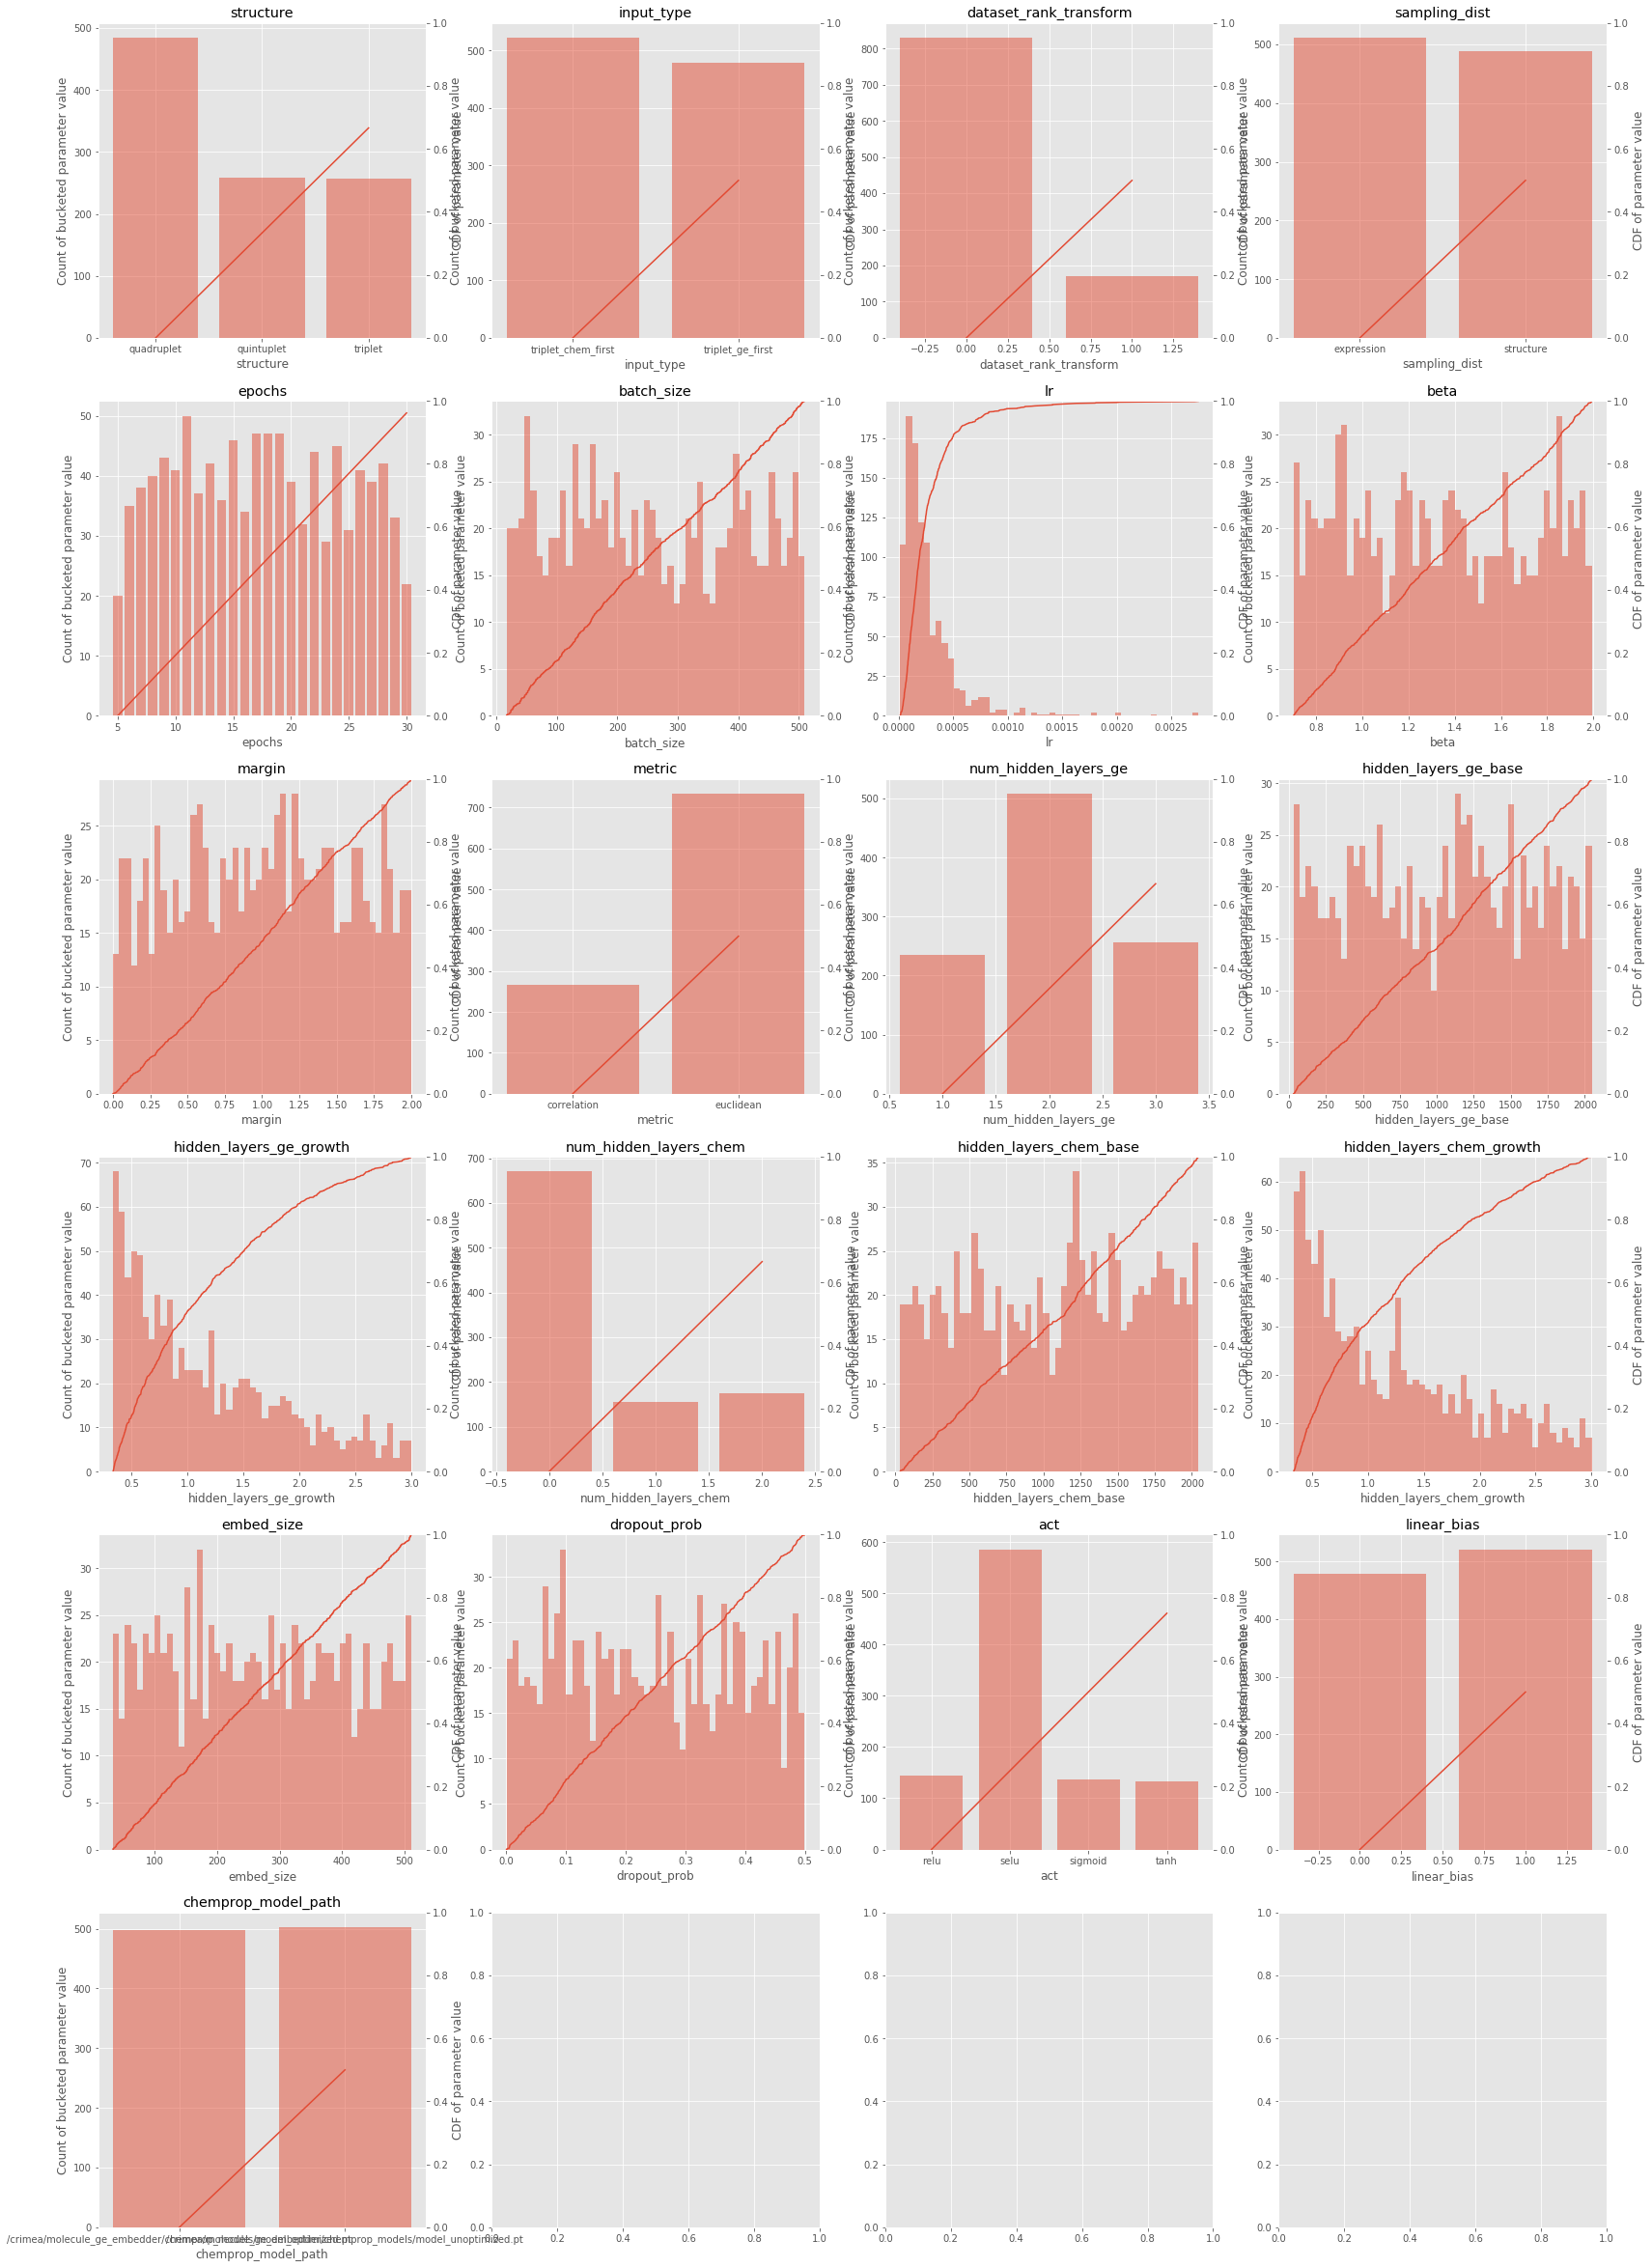

In [71]:
plot_config(HYPERPARAMETER_SEARCH_DIR)

## Errors

In [5]:
errors = get_errors(ANALYSIS_DIRS)

In [6]:
len(errors)

35

In [7]:
print(set(k for k, v in errors.items() if v[2]))

set()


In [8]:
filt_errors = {
    k: v for k, v in errors.items() if v[0] != True \
    and not v[2] \
    and v[1] > datetime.strptime('01/04/20 15:00', '%m/%d/%y %H:%M')
}

pprint({k: (v[0], str(v[1]), v[2], v[3]) for k, v in filt_errors.items()})

{'019941122d08c3422bedfbdab37f3388': (FileNotFoundError(2, 'No such file or directory'),
                                      '2020-01-31 18:07:38.276851',
                                      False,
                                      ({'l1000_sigs_path': '/crimea/molecule_ge_embedder/datasets/lincs_level3_perts_shared_9_cellLines.pkl'},
                                       {'act': 'selu',
                                        'batch_size': 405.0,
                                        'beta': 1.8459643154892227,
                                        'chemprop_model_path': '/crimea/molecule_ge_embedder/chemprop_models/model_optimized.pt',
                                        'dataset_rank_transform': False,
                                        'dropout_prob': 0.22907366727502326,
                                        'embed_size': 149.0,
                                        'epochs': 28.0,
                                        'hidden_layers_chem_base': 1975.0,

                                        'structure': 'quadruplet'})),
 '9a2276de4209c637e315fb27c4b1dfd9': (FileNotFoundError(2, 'No such file or directory'),
                                      '2020-01-31 18:08:02.040878',
                                      False,
                                      ({'l1000_sigs_path': '/crimea/molecule_ge_embedder/datasets/lincs_level3_perts_shared_9_cellLines.pkl'},
                                       {'act': 'sigmoid',
                                        'batch_size': 493.0,
                                        'beta': 1.0870882367373236,
                                        'chemprop_model_path': '/crimea/molecule_ge_embedder/chemprop_models/model_optimized.pt',
                                        'dataset_rank_transform': True,
                                        'dropout_prob': 0.2881313523163291,
                                        'embed_size': 157.0,
                                        'epochs': 19.0,
   

## Results

In [4]:
config, results_raw, exp_configs, params, trials = read_many_dirs(
    ANALYSIS_DIRS, tqdm=tqdm_notebook, overwrite=True
)

print("Found %d samples" % len(results_raw))

/data/scratch/mmd/molecule_ge_embeddings/hyperparameter_search_01_31_2020/lincs_level3_perts_shared_9_cellLines/hyperparameter_search_args.json
/data/scratch/mmd/molecule_ge_embeddings/hyperparameter_search_01_31_2020/lincs_level3_perts_shared_9_cellLines/hyperparameter_search_config.json
/data/scratch/mmd/molecule_ge_embeddings/hyperparameter_search_01_31_2020/lincs_level3_perts_shared_9_cellLines/config_samples.pkl
Found 65 samples


In [5]:
trials.best_trial['result']['loss']

527.0

In [8]:
trials.best_trial['tid']

'35c2bd2edeb5f11fa53f9241478ee399'

ValueError: zero-size array to reduction operation minimum which has no identity

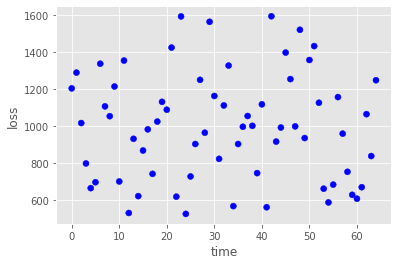

In [72]:
hyplt.main_plot_history(trials)

Showing Histogram of 65 jobs


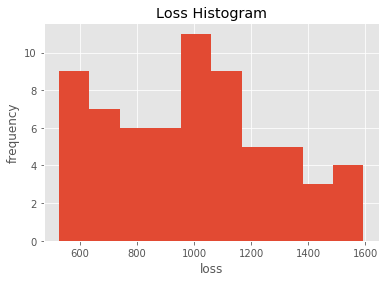

In [73]:
hyplt.main_plot_histogram(trials)

## Analysis of Results

In [64]:
with open(os.path.join(HYPERPARAMETER_SEARCH_DIR, 'config_samples.pkl'), mode='rb') as f:
    param_samples = pickle.load(f)

param_cdfs = {}
for p, vals in param_samples.items():
    sorted_vals = sorted(list(set(vals)))
    param_cdfs[p] = (sorted_vals, [np.mean([v <= sv for v in vals]) for sv in sorted_vals])

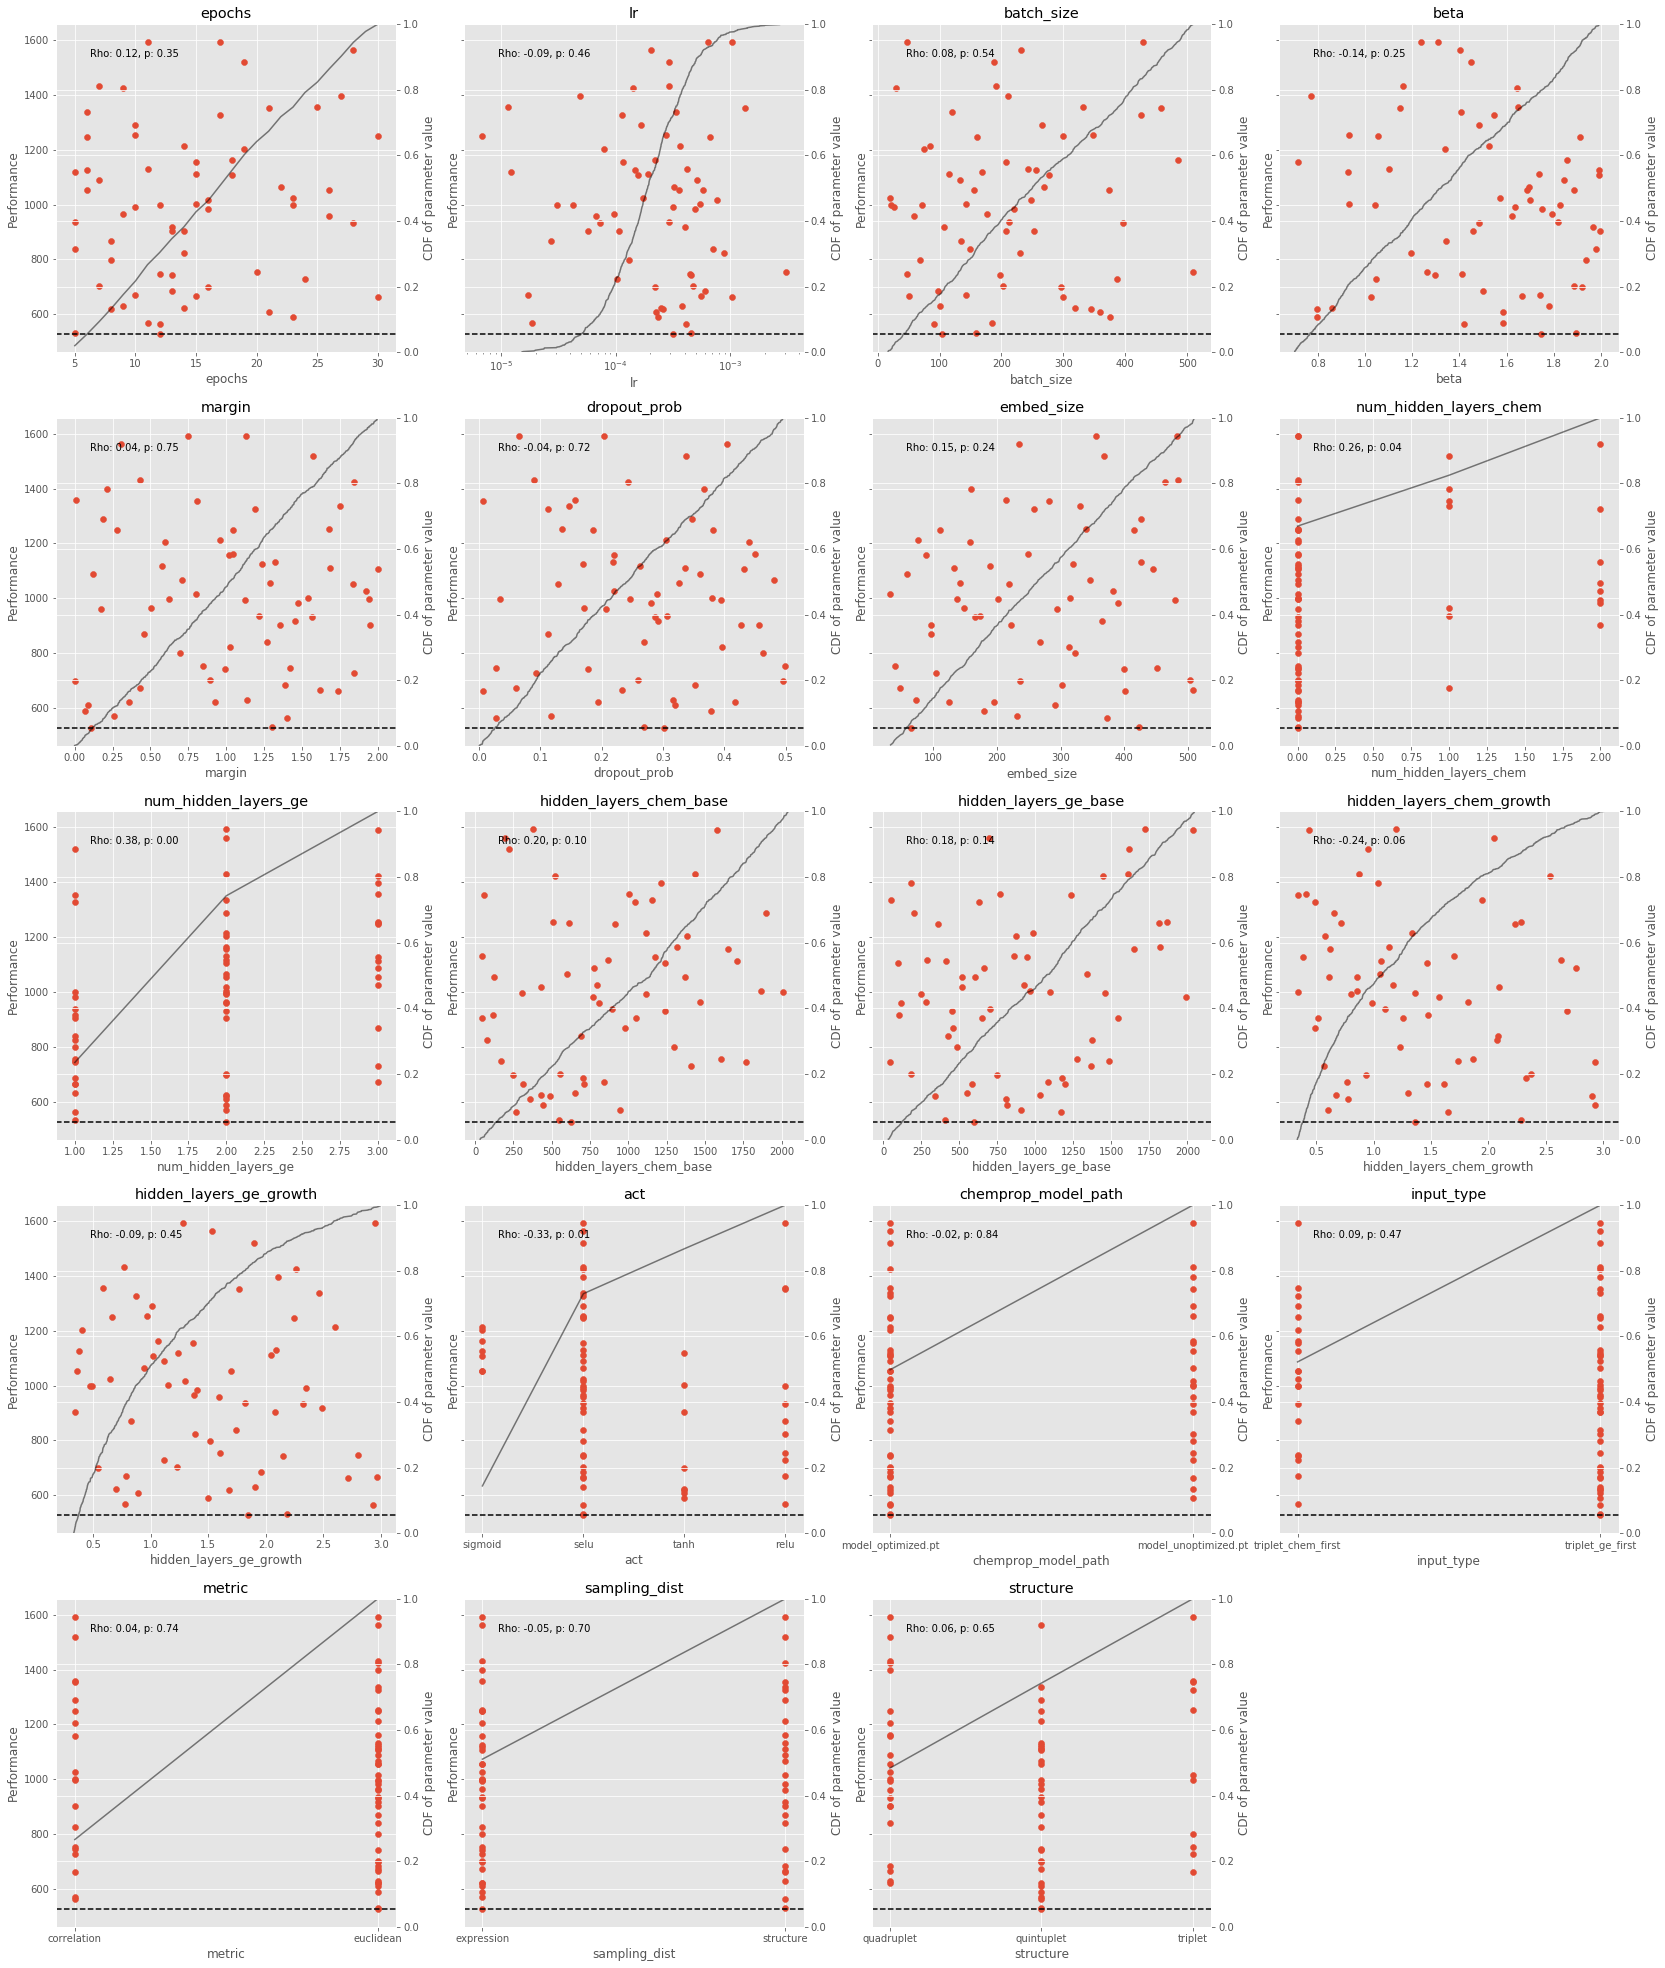

In [74]:
params_cont = [
    'epochs', 'lr', 'batch_size', 'beta', 'margin', 'dropout_prob',
    'embed_size', 'num_hidden_layers_chem', 'num_hidden_layers_ge',
    'hidden_layers_chem_base', 'hidden_layers_ge_base', 'hidden_layers_chem_growth',
    'hidden_layers_ge_growth',
]
categorical_params = [
    'act', 'chemprop_model_path', 'input_type', 'metric', 'sampling_dist', 'structure'
]

params_flt = params_cont + categorical_params

N = len(params_flt)
W = math.floor(math.sqrt(N))
H = math.ceil(N / W)

fig, axes = plt.subplots(nrows=H, ncols=W, sharey=True, figsize=(7*W, 7*H))
axes = list(itertools.chain.from_iterable(axes))

params_to_axes = {p: ax for p, ax in zip(params_flt, axes)}
for ax in axes[len(params_flt):]: ax.axis('off')
    
runs = list(params.keys())

for p, ax in params_to_axes.items():
    if p == 'lr': ax.set_xscale('log')
    ax.set_title(p)
    ax.set_ylabel('Performance')
    ax.set_xlabel(p)
    if p in param_cdfs:
        cdf_ax = ax.twinx()
        cdf_ax.set_ylim(0, 1)
        cdf_ax.set_ylabel('CDF of parameter value')
        cdf_X, cdfs = param_cdfs[p]

        cdf_ax.plot(cdf_X, cdfs, color='k', alpha=0.5)
            
    allowed_vals = [params[r][p] for r in runs]    
    if not allowed_vals: continue
    if p == 'chemprop_model_path': allowed_vals = [v.split('/')[-1] for v in allowed_vals]
    allowed_results = [results_raw[r]['Val   (Pert):']['median_rank'] for r in runs]

    X = allowed_vals
    Y = allowed_results
    
#     try:
#         X = sorted(list(set(allowed_vals))) # X might be oversampled.
#     except:
#         print(p, set(allowed_vals))
#         raise

#     # First group by x
#     Y = [[y for x2, y in zip(allowed_vals, allowed_results) if x2 == x] for x in X]
    # Then post-process.
    Y = [np.mean(ys) for ys in Y]

    try:
        rho, p_val = ss.spearmanr(allowed_vals, allowed_results)
        text = "Rho: %.2f, p: %.2f" % (rho, p_val)

        ax.text(0.1, 0.9, text, transform=ax.transAxes)
    except Exception as e:
        print("Failed to compute spearmanr for %s" % p)
        print(e)
        pass


    ax.scatter(X, Y)

    ax.axhline(y=trials.best_trial['result']['loss'], linestyle='dashed', color='k')